In [8]:
import numpy as np
import pandas as pd

In [1]:
from vresutils import reatlas as vreatlas, grid as vgrid, shapes as vshapes, landuse as vlanduse
from generation import resource
from load.europe import timeseries_europe

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import vresutils.plot as vplot

In [3]:
cutout = vreatlas.Cutout(username='becker', cutoutname='Europe_2011_2014')

In [4]:
ocean_depth_cutoff = 50 # in m or None

windturbines = dict(onshore='Vestas_V112_3MW', offshore='NREL_ReferenceTurbine_5MW_offshore')
solarpanel = dict(panel='KANENA', orientation='latitude_optimal')

# Potentials

\*potentials are meant to hold a value of $x \, MW/km^2$ for each grid cell determined from landuse data, it is later multiplied by the cell areas to determine the maximum grid cell production. For vlanduse.corine_for_cutout to work properly one needs the python package rasterio and the gdalwarp command. vlanduse.corine_for_cutout takes a list of corine grid_codes as input.

wind is preferred from PhD thesis by ed sharp p. 177

solar comes from everything but forests and waters

A homogeneous value of $1 \, MW/km^2$ is assumed for wind onshore/offshore and solar. FIX.

In [9]:
%%time
onshorepotentials = 2. #vlanduse.corine_for_cutout(cutout, [12, 13, 14, 18, 23, 24, 25, 26, 27, 28, 29, 35, 36]) * 2.
offshorepotentials = 2.
#solarpotentials = vlanduse.corine_for_cutout(cutout, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
#                                                      19, 20, 21, 22, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]) * 1.
solarpotentials = 17. #vlanduse.corine_for_cutout(cutout, [1, 2, 3, 4, 5, 6, 12, 13, 14, 18, 26, 27, 28, 29]) * 17.


CPU times: user 3 µs, sys: 4 µs, total: 7 µs
Wall time: 16 µs


NameError: name 'windpotentials' is not defined

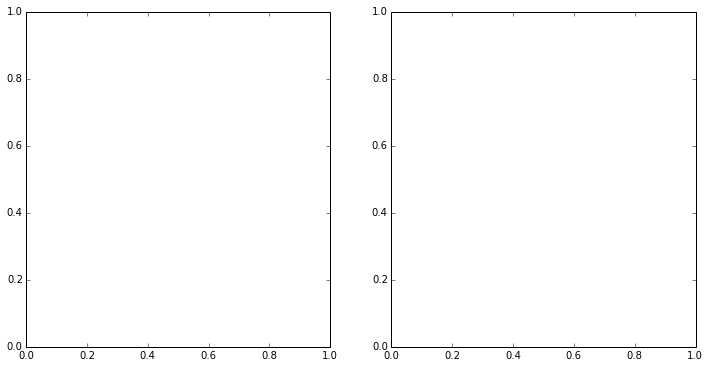

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
ax_iter = axes.flat
for ax, data in zip(axes.flat, [windpotentials, solarpotentials]):
    im = ax.imshow(data, extent=cutout.extent, cmap='viridis')
    vplot.draw_basemap(ax=ax)
fig.tight_layout()

# Time-Series

## Generation

In [10]:
partition = vreatlas.partition_from_emil(cutout)

Serving call to nuts1 from file vresutils.shapes.nuts1__.pickle of cache: 6.3 msec


### Masks

Masks are used to adjust the plain capacity factor layout (i.e. one turbine/m^2-panel at the location of a grid cell) by their geographical potential in terms of MW. They are constructed by combining landuse-specific $MW/km^2$ coefficients (\*potentials) with the actual grid cell area in $km^2$.

In [11]:
reatlas_cell_areas = np.asarray(map(vshapes.area, cutout.grid_cells())).reshape(cutout.shape)*1e-6

In [12]:
onshoremap = cutout.meta['onshoremap']
onshoremask = reatlas_cell_areas * onshorepotentials * onshoremap
solarmask = reatlas_cell_areas * solarpotentials * onshoremap
offshoremask = reatlas_cell_areas * offshorepotentials * (1. - onshoremap)

In [13]:
if ocean_depth_cutoff is not None:
    offshoremask *= (cutout.meta['heights'] > -ocean_depth_cutoff)

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


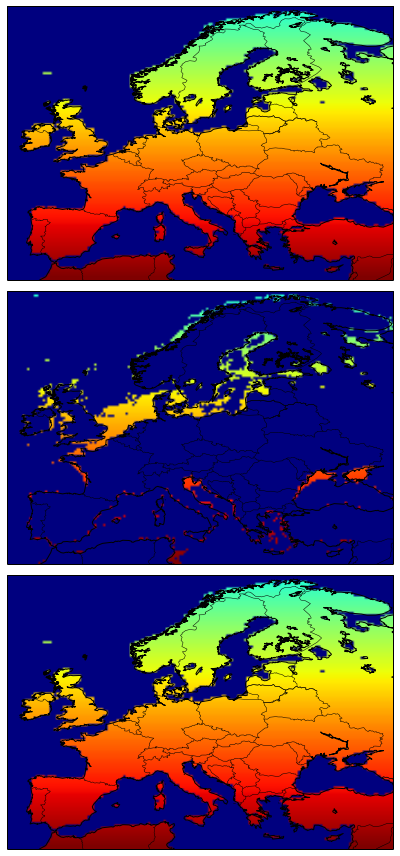

In [136]:
fig, axes = plt.subplots(3, 1, figsize=(8,12))
ax_iter = axes.flat
for ax, data in zip(axes.flat, [onshoremask, offshoremask, solarmask]):
    ax.imshow(data, extent=cutout.extent, cmap='jet')
    vplot.draw_basemap(ax=ax)
fig.tight_layout()

In [14]:
panel_ = pd.Panel({name : pd.DataFrame(par) for name,par in zip(partition.index, partition)})
EUmask=panel_.any(axis=0)

EUonshoremap = onshoremap*EUmask
EUoffshoremap = (offshoremask>0)*EUmask

In [15]:
partition.index

Index([u'AL', u'AT', u'BA', u'BE', u'BG', u'CH', u'CZ', u'DE', u'DK', u'EE',
       u'ES', u'FI', u'FR', u'GB', u'GR', u'HR', u'HU', u'IE', u'IT', u'LT',
       u'LU', u'LV', u'ME', u'MK', u'NL', u'NO', u'PL', u'PT', u'RO', u'RS',
       u'SE', u'SI', u'SK'],
      dtype='object')

### REAtlas

In [20]:
%%time
windlayout = resource.capacity_factor_layout(windturbines, cutout)
onshore = resource.unit_capacity_timeseries(dict(onshore=windturbines['onshore']), partition,
                                            onshoremask * windlayout, cutout)
offshore = resource.unit_capacity_timeseries(dict(offshore=windturbines['offshore']), partition,
                                             offshoremask * windlayout, cutout)

CPU times: user 446 ms, sys: 918 µs, total: 447 ms
Wall time: 53.7 s


In [27]:
%%time
solarlayout = resource.capacity_factor_layout(solarpanel, cutout)
solar = resource.unit_capacity_timeseries(solarpanel, partition, solarlayout * solarmask, cutout)

CPU times: user 374 ms, sys: 0 ns, total: 374 ms
Wall time: 1min 14s


In [73]:
onshore.drop(['AL','ME','MK'],axis=1,inplace=True)
offshore.drop(['AL','ME','MK'],axis=1,inplace=True)
solar.drop(['AL','ME','MK'],axis=1,inplace=True)

In [16]:
import os
timeseries_folder_name='timeseries_normed/'

In [ ]:
if not os.path.isdir(timeseries_folder_name):
    os.mkdir(timeseries_folder_name)

onshore.to_csv(os.path.join(timeseries_folder_name,'onshore_normwindp.csv'))
offshore.to_csv(os.path.join(timeseries_folder_name,'offshore_normwindp.csv'))
solar.to_csv(os.path.join(timeseries_folder_name,'normsolarp.csv'))

onshore.to_pickle(os.path.join(timeseries_folder_name,'onshore_normwindp.pickle'))
offshore.to_pickle(os.path.join(timeseries_folder_name,'offshore_normwindp.pickle'))
solar.to_pickle(os.path.join(timeseries_folder_name,'normsolarp.pickle'))

In [18]:
import os
onshore = pd.read_pickle(os.path.join(timeseries_folder_name,'onshore_normwindp.pickle'))
onshore.index = pd.DatetimeIndex(onshore.index.values)
offshore = pd.read_pickle(os.path.join(timeseries_folder_name,'offshore_normwindp.pickle'))
offshore.index = pd.DatetimeIndex(offshore.index.values)
solar = pd.read_pickle(os.path.join(timeseries_folder_name,'normsolarp.pickle'))
solar.index = pd.DatetimeIndex(solar.index.values)

In [28]:
EUonshorewindlayout = windlayout*EUonshoremap
EUoffshorewindlayout = windlayout*EUoffshoremap
EUsolarlayout = solarlayout*EUonshoremap

In [29]:
EUonshorewindlayout.to_pickle('EUonshorewindlayout.pickle')
EUoffshorewindlayout.to_pickle('EUoffshorewindlayout.pickle')
EUsolarlayout.to_pickle('EUsolarlayout.pickle')

In [17]:
EUonshorewindlayout = pd.read_pickle('EUonshorewindlayout.pickle')
EUoffshorewindlayout = pd.read_pickle('EUoffshorewindlayout.pickle')
EUsolarlayout = pd.read_pickle('EUsolarlayout.pickle')

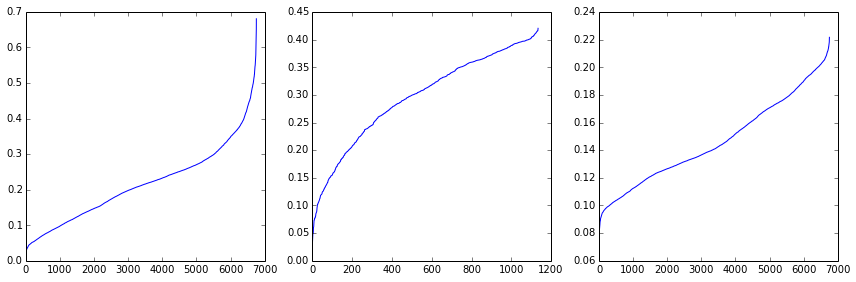

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))
axes[0].plot(np.sort((EUonshorewindlayout).values[EUonshoremap.values>0]))
axes[1].plot(np.sort((EUoffshorewindlayout).values[EUoffshoremap.values>0]))
axes[2].plot(np.sort((EUsolarlayout).values[EUonshoremap.values>0]))

fig.tight_layout()

In [20]:
EUon = (EUonshorewindlayout).values[EUonshoremap.values>0]
np.percentile(EUon, [90.,95.,99.,99.9,100])

array([ 0.35687999,  0.40731322,  0.51745742,  0.6146484 ,  0.68067078])

u'/home/vres/data/david/playground/pypsa/examples/europe'

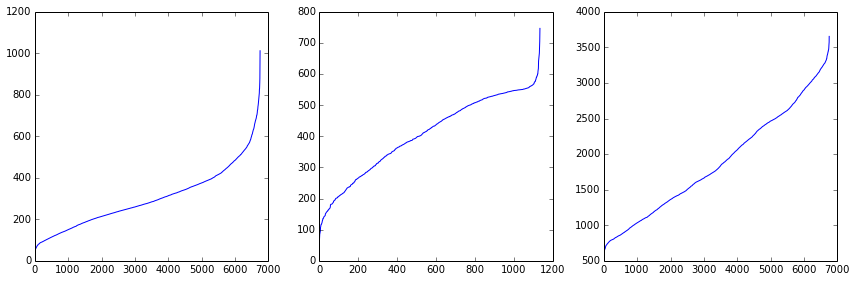

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))
axes[0].plot(np.sort((EUonshorewindlayout*onshoremask).values[EUonshoremap.values>0]))
axes[1].plot(np.sort((EUoffshorewindlayout*offshoremask).values[EUoffshoremap.values>0]))
axes[2].plot(np.sort((EUsolarlayout*solarmask).values[EUonshoremap.values>0]))

fig.tight_layout()
fig.savefig('EUpotential_curves.svg')
%pwd

In [273]:
print((EUonshorewindlayout*onshoremask).sum().sum(), (EUoffshorewindlayout*offshoremask).sum().sum(), (EUsolarlayout*solarmask).sum().sum())

(2026485.3263149264, 459723.11503818556, 12707411.489980029)


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


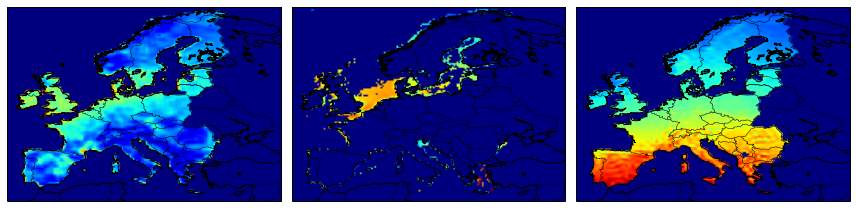

In [63]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

for ax, data in zip(axes.flat, [EUonshorewindlayout*onshoremask, EUoffshorewindlayout*offshoremask, EUsolarlayout*solarmask]):
    ax.imshow(data, extent=cutout.extent, cmap='jet')
    vplot.draw_basemap(ax=ax)
fig.tight_layout()
fig.savefig('EUlayouts.svg')

### Determine peak production

In [77]:
def renorm(x,partition_x,quantile=1.): return x / np.percentile(x[partition_x],quantile*100.)
onshoremap = cutout.meta['onshoremap']

def p_max_pu(quantile):
    onshore_p_max_pu = partition.map(lambda x: (renorm(x * windlayout * onshoremap, x, quantile) * onshoremask).sum())
    offshore_p_max_pu = partition.map(lambda x: (renorm(x * windlayout * (1.-onshoremap), x, quantile) * offshoremask).sum())
    solar_p_max_pu = partition.map(lambda x: (renorm(x * solarlayout * onshoremap, x, quantile) * solarmask).sum())
    return onshore_p_max_pu, offshore_p_max_pu, solar_p_max_pu

In [99]:
on,off,sol=p_max_pu(1.)

In [100]:
on.drop(['AL','ME','MK'],inplace=True)

In [114]:
lo=load[on.keys()]['2011':'2014'].sum()

In [92]:
# Maximum gamma per country
def max_gamma(timeseries,p_nom_max,mean_load):
    return timeseries.mean() * p_nom_max / mean_load

mean_load = load[on.keys()]['2011':'2014'].mean() * 1e3 # in MW
pd.concat({name : max_gamma(timser,p_nom_max,mean_load) for name,timser,p_nom_max in 
           zip(['on','off','sol'],[onshore,offshore,solar],[onshore_p_nom_max,offshore_p_nom_max,solar_p_nom_max])},axis=1)

#pd.concat({'on': max_gamma(onshore,onshore_p_nom_max,mean_load),
#           'off': max_gamma(offshore,offshore_p_nom_max,mean_load)})

off         on         sol
AT        NaN   1.342896   28.210932
BA        NaN   3.982062   99.215182
BE   0.320495   1.256394    7.047092
BG   0.246447   3.258530   69.659312
CH        NaN   0.964231   18.997613
CZ        NaN   2.755660   26.298875
DE   0.962652   1.745576   13.931467
DK  18.469044   8.669996   28.996354
EE  13.337383  25.480625  104.478385
ES   0.166045   3.124419   51.607629
FI   3.591605  10.878163   53.706676
FR   0.697276   2.337198   22.172134
GB   3.431600   3.939349   12.578903
GR   3.764374   2.495180   64.807787
HR   3.088668   4.318453   78.173773
HU        NaN   4.150703   56.851454
IE   3.899219  14.370825   39.946758
IT   0.260682   1.052604   23.687485
LT   2.337533  15.893914  106.506577
LU        NaN   1.831309   10.636803
LV  12.319322  33.428414  155.466158
NL   5.326647   1.403340    6.008405
NO   1.889904   5.839311   38.089988
PL   0.548496   4.894465   38.418160
PT   0.263165   2.594113   47.714040
RO   1.038691   4.634392  106.892264
RS        NaN   2.348727   46.866492
SE   3.645917   8.080165   51.581481
SI        NaN   1.023889   32.286171
SK        NaN   2.107468   38.286082

In [95]:
offshore_p_nom_max /1e3

AT           NaN
BA           NaN
BE      5.707799
BG      4.158720
CH           NaN
CZ           NaN
DE     93.380927
DK    125.672579
EE     26.045776
ES     18.399333
FI     78.277699
FR     84.187828
GB    223.534313
GR     50.596653
HR     24.070286
HU           NaN
IE     24.299191
IT     41.311518
LT      5.928457
LU           NaN
LV     21.670956
NL    118.784253
NO     65.234978
PL     19.535458
PT      5.665643
RO     17.444600
RS           NaN
SE    129.461726
SI           NaN
SK           NaN
dtype: float64

Country
AT     7.862620
BA     1.408448
BE     9.717245
BG     4.211341
CH     5.433821
CZ     7.157005
DE    54.877863
DK     3.820724
EE     0.908921
ES    28.439871
FI     9.604147
FR    54.820963
GB    34.573810
GR     5.532740
HR     1.957422
HU     4.466097
IE     2.942613
IT    36.177659
LT     1.203699
LU     0.686713
LV     0.810723
NL    12.648086
NO    14.415786
PL    16.671446
PT     5.627390
RO     5.980463
RS     4.520917
SE    15.856880
SI     1.489137
SK     3.177745
dtype: float64

In [116]:
onshore.sum() * on /1e3/ lo

AT     1.304076
BA     3.936142
BE     1.130277
BG     3.005155
CH     0.956857
CZ     2.728080
DE     1.471681
DK     7.953258
EE    22.468606
ES     1.922509
FI     9.230320
FR     1.792053
GB     3.168309
GR     1.580566
HR     4.029244
HU     3.854983
IE    11.995156
IT     0.755940
LT    13.990487
LU     1.822148
LV    29.532842
NL     1.206892
NO     3.940596
PL     3.730591
PT     2.221624
RO     3.122887
RS     2.344067
SE     7.198775
SI     1.011149
SK     1.928788
dtype: float64

In [84]:
partition.map(lambda x: (x*windlayout*onshoremap).sum()) * on /4.

AL       15259.307240
AT      219447.841445
BA       67856.472505
BE      120038.509260
BG      346548.184797
CH       56282.242733
CZ      473983.764533
DE    10176563.758508
DK      595116.246379
EE      440137.236806
ES    10319956.055043
FI    15838436.320615
FR    18273813.316033
GB    11391249.133303
GR      277182.494027
HR      110478.175331
HU      485138.954129
IE      991644.358331
IT     2529989.787708
LT      429677.407032
LU        1240.043130
LV      659090.449022
ME        6671.142967
MK       12983.137480
NL      204908.811613
NO    11177204.958260
PL     8267126.398480
PT      298724.686976
RO     1598042.246787
RS      208447.559967
SE    22391887.213908
SI        7267.631861
SK       89265.643488
dtype: float64

In [137]:
def renorm(x): return x / x.max()
onshoremap = cutout.meta['onshoremap']
onshore_p_max_pu = partition.map(lambda x: (renorm(x * windlayout * onshoremap) * onshoremask).sum())
offshore_p_max_pu = partition.map(lambda x: (renorm(x * windlayout * (1.-onshoremap)) * offshoremask).sum())
solar_p_max_pu = partition.map(lambda x: (renorm(x * solarlayout * onshoremap) * solarmask).sum())

(123, 173)

In [134]:
onshore_p_max_pu / 1e3

AL     18.603382
AT     70.964799
BA     53.334213
BE     36.874965
BG     91.036126
CH     46.743283
CZ    102.028107
DE    297.960993
DK     65.949029
EE     58.799190
ES    308.445880
FI    313.007354
FR    397.729198
GB    283.257450
GR     55.587156
HR     49.086767
HU    107.813076
IE     85.785738
IT    189.933954
LT     58.534912
LU      5.216277
LV     73.837175
ME     20.196938
MK     34.092367
NL     41.916898
NO    224.405808
PL    259.134561
PT     69.974234
RO    135.699591
RS     96.225651
SE    405.549769
SI     19.012251
SK     45.593864
dtype: float64

#### w/o renorm

In [135]:
pd.concat({'w/ renorm': onshore_p_max_pu,
           'w/o renorm': partition.map(lambda x: (x * onshoremask).sum())}, axis=1) /1e3

w/ renorm   w/o renorm
AL   18.603382    58.213279
AT   70.964799   171.314637
BA   53.334213   102.291550
BE   36.874965    61.417677
BG   91.036126   225.425811
CH   46.743283    77.873433
CZ  102.028107   156.438527
DE  297.960993   724.367707
DK   65.949029   103.073490
EE   58.799190   100.779142
ES  308.445880   992.320361
FI  313.007354   669.603024
FR  397.729198  1090.049759
GB  283.257450   495.953021
GR   55.587156   239.290174
HR   49.086767   110.953456
HU  107.813076   180.954490
IE   85.785738   140.705368
IT  189.933954   604.010829
LT   58.534912   128.203046
LU    5.216277     6.250199
LV   73.837175   133.828495
ME   20.196938    24.801370
MK   34.092367    52.375129
NL   41.916898    71.254932
NO  224.405808   666.104325
PL  259.134561   627.373535
PT   69.974234   178.335845
RO  135.699591   478.298236
RS   96.225651   154.193680
SE  405.549769   874.814112
SI   19.012251    36.834591
SK   45.593864    95.835680

In [79]:
on /1e3

AL     19.951322
AT     73.081483
BA     53.959491
BE     40.991834
BG     98.717322
CH     47.106177
CZ    103.065460
DE    353.434620
DK     71.896377
EE     66.685292
ES    501.293636
FI    368.908021
FR    518.748472
GB    352.211128
GR     87.758336
HR     52.613088
HU    116.090164
IE    102.781662
IT    264.487579
LT     66.502467
LU      5.242802
LV     83.581539
ME     20.240240
MK     34.661553
NL     48.742558
NO    332.551276
PL    339.999040
PT     81.711132
RO    201.390920
RS     96.422445
SE    455.229727
SI     19.252880
SK     49.820461
dtype: float64

In [21]:
offshore_p_max_pu

AL      5179.566994
AT              NaN
BA              NaN
BE      5607.444955
BG      4135.171990
CH              NaN
CZ              NaN
DE     92726.854091
DK    123845.949343
EE     25968.625757
ES     17387.377946
FI     76651.537187
FR     80594.909234
GB    222491.042838
GR     48605.361704
HR     23924.675238
HU              NaN
IE     24143.100062
IT     39427.389425
LT      5898.414650
LU              NaN
LV     21654.705186
ME      3263.171649
MK              NaN
NL    118220.763592
NO     62513.113515
PL     19056.063552
PT      5602.224278
RO     16378.664863
RS              NaN
SE    122691.293096
SI              NaN
SK              NaN
dtype: float64

In [22]:
solar_p_max_pu

AL     454939.966926
AT    1307432.853638
BA     781765.107870
BE     481960.974880
BG    1555631.991647
CH     568040.397145
CZ    1138476.379708
DE    4926909.454108
DK     789252.416639
EE     727474.820882
ES    7335893.945193
FI    4357252.251899
FR    6821205.594143
GB    3269834.151415
GR    1760213.407579
HR     838077.958288
HU    1456390.936981
IE     941995.944048
IT    4385706.319885
LT     972835.027064
LU      49921.218070
LV     969049.014312
ME     191390.745767
MK     408215.113875
NL     549296.973876
NO    4287896.110638
PL    4435546.649178
PT    1348192.308494
RO    3481012.059415
RS    1171063.511515
SE    6067421.590889
SI     293310.042078
SK     729930.240895
dtype: float64

## Load

In [102]:
load = timeseries_europe()

Serving call to read_entsoe_consumption from file load.europe.read_entsoe_consumption_d446ec8416cfa4a02b903ea99e74c27f3a25524a_.pickle of cache: 501.2 msec


In [107]:
lo=load['2011':'2014'].sum()

## Choose common data boundaries

In [16]:
graph = vgrid.eu()

In [67]:
timeseries = pd.Panel(dict(load=load, windon=onshore, windoff=offshore, solar=solar))
timeseries = timeseries.ix[:,:,graph.nodes()]
timeseries.dropna(axis=1, inplace=True)

In [68]:
timeseries

<class 'pandas.core.panel.Panel'>
Dimensions: 4 (items) x 35062 (major_axis) x 30 (minor_axis)
Items axis: load to windon
Major_axis axis: 2011-01-01 00:00:00+00:00 to 2014-12-31 22:00:00+00:00
Minor_axis axis: AT to LT